# Step 1: Parse Emotion Annotations for Video-Only
Objective: Extract video segments corresponding to each utterance using the balanced CSV files (iemocap_video_balanced.csv and iemocap_master_table_balanced.csv).

In [1]:
import os
import cv2
import pandas as pd
from tqdm import tqdm

# Paths to the CSV files
video_csv_path = 'iemocap_video_balanced.csv'
master_csv_path = 'iemocap_master_table_balanced.csv'

# Load the CSV files
video_df = pd.read_csv(video_csv_path)
master_df = pd.read_csv(master_csv_path)

# Directory to save the extracted video segments
output_dir = 'video_segments'
os.makedirs(output_dir, exist_ok=True)

# Iterate over each row in the master DataFrame
for index, row in tqdm(master_df.iterrows(), total=master_df.shape[0]):
    utterance_id = row['utterance_id']
    video_path = row['video_dialog_path']
    start_time = row['start']
    end_time = row['end']
    emotion = row['emotion']

    # Construct the full path to the video file
    full_video_path = os.path.join(video_path)

    # Check if the video file exists
    if not os.path.exists(full_video_path):
        print(f"Video file {full_video_path} not found.")
        continue

    # Load the video file
    cap = cv2.VideoCapture(full_video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the start and end frames
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    # Set the video capture to the start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Define the codec and create VideoWriter object
    segment_filename = f"{utterance_id}.avi"
    segment_path = os.path.join(output_dir, segment_filename)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(segment_path, fourcc, fps, (width, height))

    # Read and write frames from start to end
    for frame_num in range(start_frame, end_frame):
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)

    # Release resources
    cap.release()
    out.release()

100%|██████████████████████████████████████████████████████████████████████████| 14792/14792 [1:38:31<00:00,  2.50it/s]


# Step 2: Extract Visual Features from Video Segments (Embeddings)
Goal: Generate embeddings for each video segment using a pre-trained deep CNN (e.g., ResNet50), storing one embedding per utterance for future fusion with audio and text.

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import tensorflow as tf

# Set paths
video_dir = 'video_segments'
embedding_output_path = 'video_embeddings_resnet50.npy'
id_output_path = 'video_embedding_ids.npy'

# Load ResNet50 (without top layer)
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Parameters
N_FRAMES = 10
IMAGE_SIZE = (224, 224)

# Initialize results
video_embeddings = []
video_ids = []

# Iterate over video files
video_files = sorted(os.listdir(video_dir))
for video_file in tqdm(video_files):
    video_path = os.path.join(video_dir, video_file)
    utterance_id = os.path.splitext(video_file)[0]
    
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        continue

    # Sample frames uniformly
    frame_indices = np.linspace(0, total_frames - 1, N_FRAMES, dtype=int)
    frames = []

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.resize(frame, IMAGE_SIZE)
        img_array = image.img_to_array(frame)
        img_array = preprocess_input(img_array)
        frames.append(img_array)

    cap.release()

    # Convert to numpy array and get embeddings
    if not frames:
        continue

    frames_array = np.array(frames)
    with tf.device('/CPU:0'):  # Use CPU if GPU runs out of memory
        frame_features = model.predict(frames_array, verbose=0)
        video_feature = np.mean(frame_features, axis=0)

    video_embeddings.append(video_feature)
    video_ids.append(utterance_id)

# Save results
np.save(embedding_output_path, np.array(video_embeddings))
np.save(id_output_path, np.array(video_ids))

print(f"Saved {len(video_embeddings)} video embeddings to {embedding_output_path}")

100%|████████████████████████████████████████████████████████████████████████████| 5550/5550 [1:07:48<00:00,  1.36it/s]


Saved 5550 video embeddings to video_embeddings_resnet50.npy


# Step 3: Train Emotion Classifier on Video Embeddings
Goal:
Use the .npy video embeddings and corresponding emotion labels from iemocap_master_table_balanced.csv to train a classifier (e.g., MLP, SVM) to predict emotions.



In [7]:
import numpy as np
import pandas as pd

# Load the video embeddings and their corresponding utterance IDs
embeddings = np.load("video_embeddings_resnet50.npy")
embedding_ids = np.load("video_embedding_ids.npy")

# Load the balanced master table
master_table = pd.read_csv("iemocap_master_table_balanced.csv")

# Ensure consistency in formatting
embedding_ids = embedding_ids.astype(str)
master_table['utterance_id'] = master_table['utterance_id'].astype(str)

# Filter master table to only include utterances for which we have embeddings
valid_mask = master_table['utterance_id'].isin(embedding_ids)
filtered_master = master_table[valid_mask].reset_index(drop=True)

# Align the embeddings with filtered utterance_ids
id_to_index = {uid: idx for idx, uid in enumerate(embedding_ids)}
embedding_indices = filtered_master['utterance_id'].map(id_to_index).values
aligned_embeddings = embeddings[embedding_indices]

# Encode labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(filtered_master['emotion'])
y = to_categorical(y_encoded)

# Final dataset
X = aligned_embeddings

# Confirm shapes
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (14792, 2048), y shape: (14792, 8)


In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define MLP model
model = Sequential([
    Dense(512, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

C:\Users\Rishuraj\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.1658 - loss: 2.2487 - val_accuracy: 0.2910 - val_loss: 1.8729
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2724 - loss: 1.8781 - val_accuracy: 0.4039 - val_loss: 1.7375
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3462 - loss: 1.7602 - val_accuracy: 0.4089 - val_loss: 1.6434
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3908 - loss: 1.6591 - val_accuracy: 0.4522 - val_loss: 1.5421
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4205 - loss: 1.5767 - val_accuracy: 0.4904 - val_loss: 1.4497
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4607 - loss: 1.4662 - val_accuracy: 0.4965 - val_loss: 1.3983
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4916 - loss: 1.4062 - val_accuracy: 0.5360 - val_loss: 1.3070
Epoch 8/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5099 - loss: 1.3315 - val_accu

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:

              precision    recall  f1-score   support

       anger       0.73      0.73      0.73       370
     excited       0.79      0.82      0.81       370
        fear       0.97      1.00      0.98       370
 frustration       0.58      0.56      0.57       370
   happiness       0.84      0.79      0.82       370
     neutral       0.59      0.52      0.55       370
     sadness       0.77      0.86      0.81       369
    surprise       0.91      0.96      0.93       370

    accuracy                           0.78      2959
   macro avg       0.77      0.78      0.78      2959
weighted avg       0.77      0.78      0.78      2959



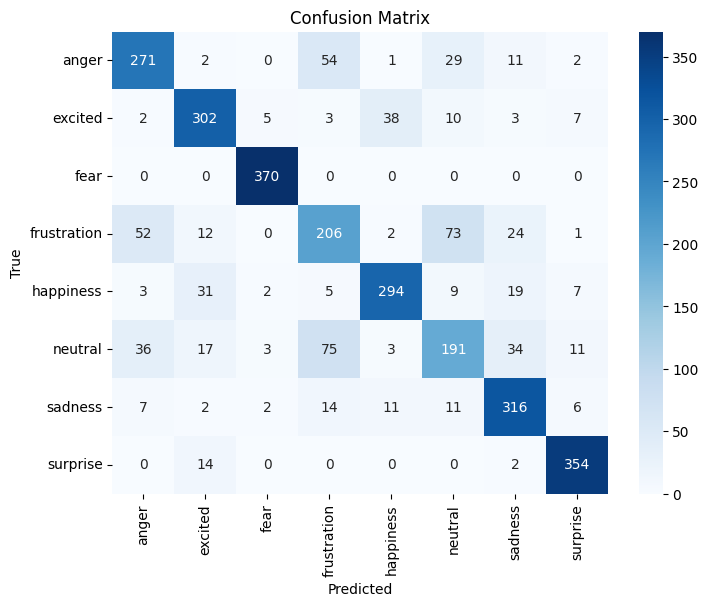

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Save model
model.save('iemocap_video_mlp_model.keras')
print("Model saved successfully as 'iemocap_video_mlp_model.keras'")

Model saved successfully as 'iemocap_video_mlp_model.keras'


### Plot training & validation accuracy

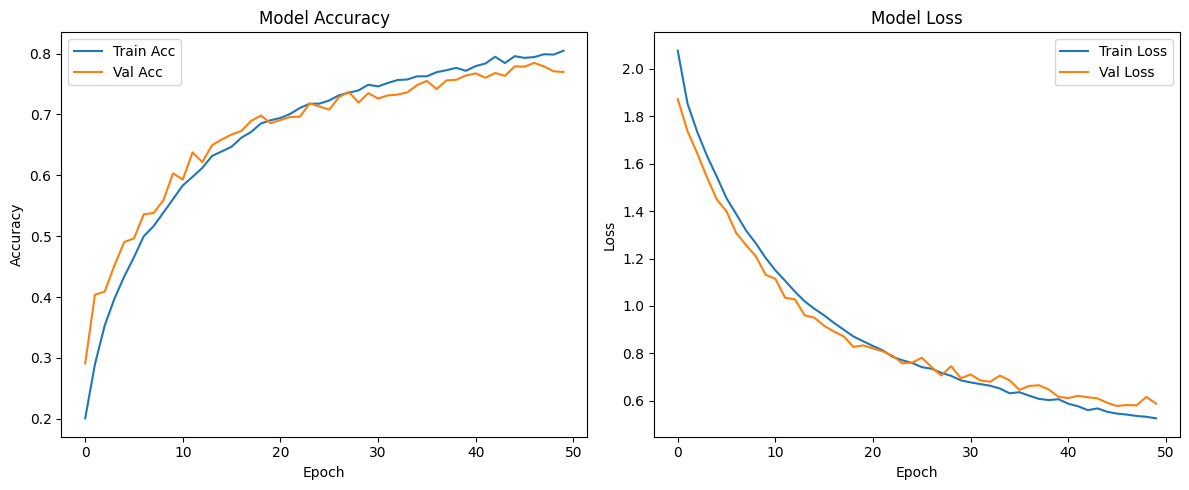

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step-by-Step for Video-Only Emotion Prediction (Verification Stage)

### Load your trained video model:

In [17]:
from tensorflow.keras.models import load_model
model = load_model("iemocap_video_mlp_model.keras")

### Load your test video features and labels:

In [18]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


### Evaluate performance:

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes, target_names=[
    'anger', 'excited', 'fear', 'frustration', 'happiness', 'neutral', 'sadness', 'surprise'
]))

              precision    recall  f1-score   support

       anger       0.73      0.73      0.73       370
     excited       0.79      0.82      0.81       370
        fear       0.97      1.00      0.98       370
 frustration       0.58      0.56      0.57       370
   happiness       0.84      0.79      0.82       370
     neutral       0.59      0.52      0.55       370
     sadness       0.77      0.86      0.81       369
    surprise       0.91      0.96      0.93       370

    accuracy                           0.78      2959
   macro avg       0.77      0.78      0.78      2959
weighted avg       0.77      0.78      0.78      2959

